# Audio Feature Extraction

In [1]:
import librosa
from glob import glob
import sys
import os

sys.path.append(os.path.abspath("../"))


In [2]:
from utils import env

audio_files = glob(os.path.join(env["DATASET_PATH"], "spotify_sample", "**", "*.mp3"), recursive=True)
len(audio_files)

11462

In [4]:
from random import choice

y, sr = librosa.load(choice(audio_files))
print(len(y))
print('Sampling rate (Hz): %d' % sr)
print('Audio length (seconds): %.2f' % (len(y) / sr))

/home/atsuya/.pyenv/versions/anaconda3-2020.11/envs/album-covers-vqvae/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


661248
Sampling rate (Hz): 22050
Audio length (seconds): 29.99


In [9]:
import IPython.display as ipd

ipd.Audio(y, rate=sr)

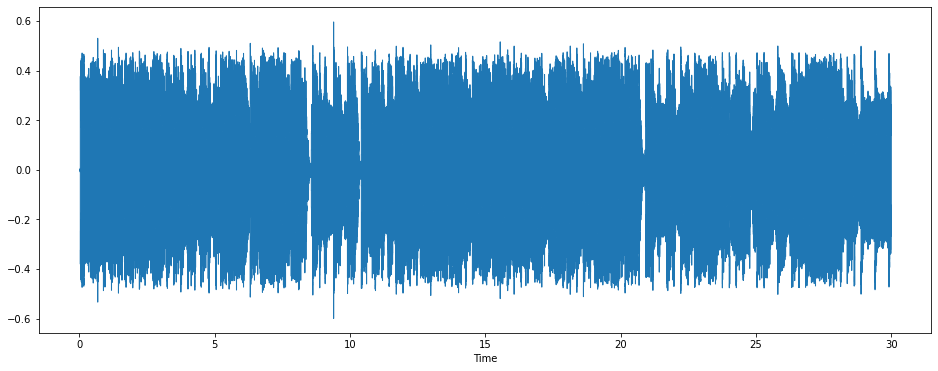

In [6]:
import matplotlib.pyplot as plt
from  librosa.display import waveshow

plt.figure(figsize=(16,6))
waveshow(y=y, sr=sr)

(1025, 1292)


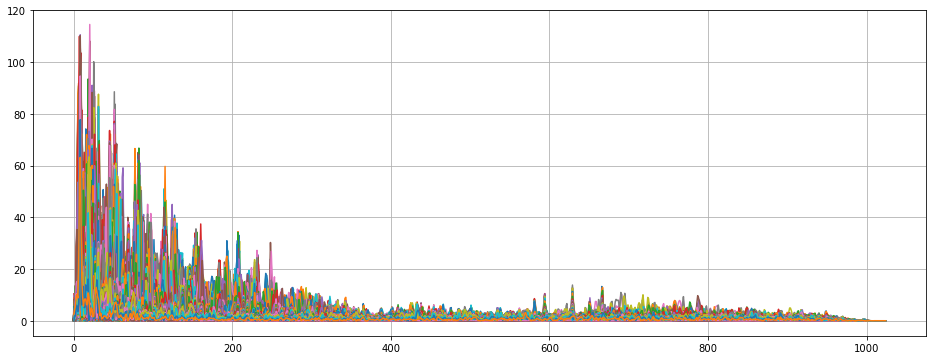

In [8]:
import numpy as np

D = np.abs(librosa.stft(y, n_fft=2048, hop_length=512))
print(D.shape)

plt.figure(figsize=(16, 6))
plt.plot(D)
plt.grid()
plt.show()

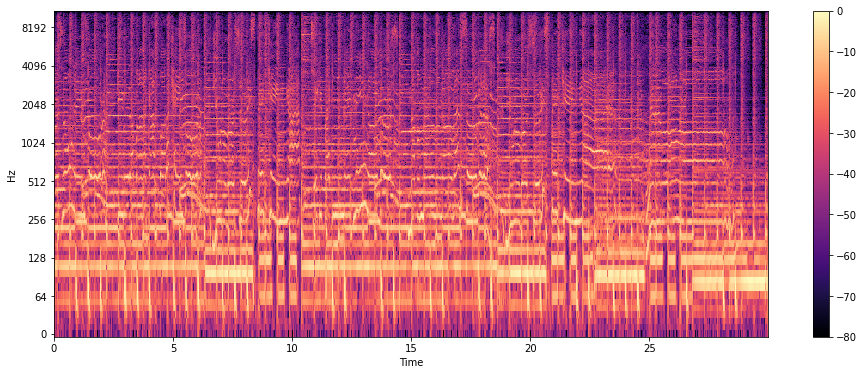

In [9]:
DB = librosa.amplitude_to_db(D, ref=np.max)

plt.figure(figsize=(16, 6))
librosa.display.specshow(DB, sr=sr, hop_length=512, x_axis='time', y_axis='log')
plt.colorbar()
plt.show()

## Extract Features

In [12]:
from sklearn.preprocessing import minmax_scale


def normalize(x, axis=0):
  return minmax_scale(x, axis=axis)


zero_crossings = librosa.zero_crossings(y, pad=False)
y_harm, y_perc = librosa.effects.hpss(y)
spectral_centroids = librosa.feature.spectral_centroid(y=y, sr=sr)[0]
spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)[0]
mfccs = librosa.feature.mfcc(y=y, sr=sr)
mfccs = normalize(mfccs, axis=1)
chromagram = librosa.feature.chroma_stft(y=y, sr=sr, hop_length=512)


print("zero_crossings:" , zero_crossings.shape)
print("y_harm:" , y_harm.shape)
print("y_perc:" , y_perc.shape)
print("spectral_centroids:" , spectral_centroids.shape)
print("spectral_rolloff:" , spectral_rolloff.shape)
print("mfccs:" , mfccs.shape)
print("chromagram:" , chromagram.shape)


zero_crossings: (661248,)
y_harm: (661248,)
y_perc: (661248,)
spectral_centroids: (1292,)
spectral_rolloff: (1292,)
mfccs: (20, 1292)
chromagram: (12, 1292)
